# Slate Star Codex Reader Survey 2018

**If you enjoy this, let's connect on LinkedIn:**

**https://www.linkedin.com/in/vincefavilla/**

I'm a psychology professor and machine learning engineer. Also, I'm in the SF Bay Area and looking for a job outside of academia. :)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


After some experimenting, I decided that it's better to analyze the data where I inferred the missing values using machine learning. This obviously isn't perfect, and we can't be certain what someone *would have* answered, but we can more accurately represent individual differences this way.

In [147]:
data = pd.read_csv('ssc2018public_inferred.csv')

data = data[[i for i in data.columns if 'Unnamed' not in i]]
print('Data has', data.shape[0], 'responses and', data.shape[1], 'features')

Data has 7260 responses and 838 features


# Demographics

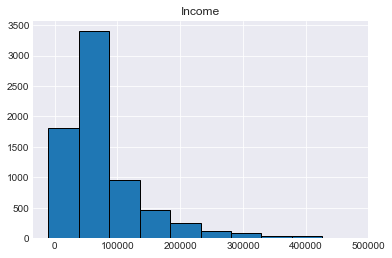

In [8]:
# Income
data[data.Income < 500000].Income.hist(edgecolor='black') # Remove the millionaire outliers
plt.title('Income')

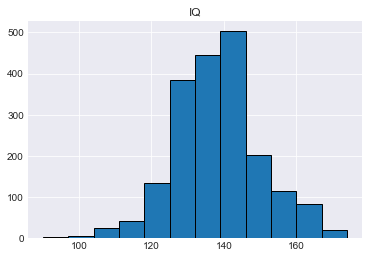

In [9]:
# IQ
data[data.IQ != data.IQ.median()].IQ.hist(edgecolor='black', bins=12)

plt.title('IQ')

We can normalize the SAT scores to account for which version of the test people took. We have a lot of really smart people in this community.

As a side note, whenever you see code along the lines of `!= .median()`, it means I'm removing the missing data I couldn't reasonably predict.

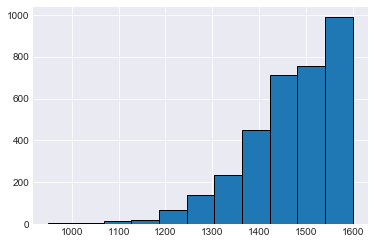

In [39]:
sat = np.where(data.SATscoresoutof1600 != data.SATscoresoutof1600.median(), data.SATscoresoutof1600/1600, np.nan)
sat = np.where(data.SATscoresoutof2400 != data.SATscoresoutof2400.median(), data.SATscoresoutof2400/2400, sat)

sat = pd.Series(sat) * 1600

sat[sat > 900].hist(edgecolor='black', bins=11)

One of my favorite things about the rationalist community is we tend to assume we're average unless we have strong evidence otherwise...

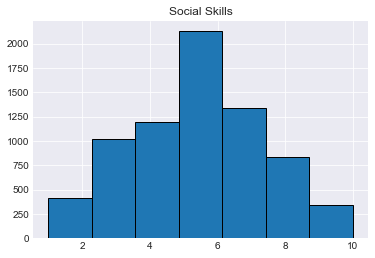

In [52]:
data.SocialSkills.hist(edgecolor='black', bins=7)
plt.title('Social Skills')

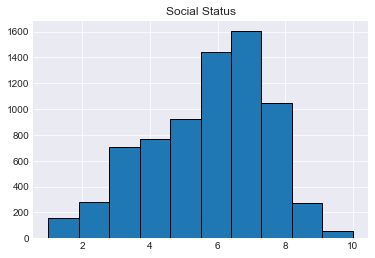

In [51]:
data.Status.hist(edgecolor='black', bins=10)
plt.title('Social Status')

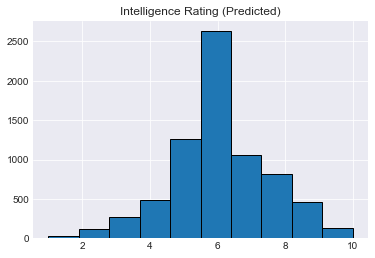

In [55]:
# "How intelligent do you think you are compared to the average reader of this blog?"
data.Percentile.hist(edgecolor='black', bins=10)
# I replaced missing values with the median -- and kept it -- 
# so this graph is a little more peaky than the others.

plt.title('Intelligence Rating (Predicted)')

Let's graph IQ vs. how people think they stack up against fellow SSC readers.

Correlation: 0.254


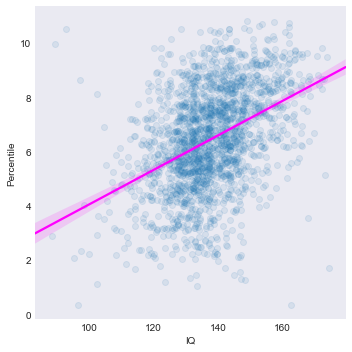

In [88]:
print('Correlation:', round(np.corrcoef(data.Percentile, data.IQ)[0,1], 3))

sns.lmplot('IQ', 'Percentile', data=data[data.IQ != data.IQ.median()],
            y_jitter=.9, x_jitter=3, scatter_kws={'alpha':.1}, line_kws={'color': 'magenta'})

The Dunning-Kruger effect is in full force in the top left. There are also a handful of very underconfident geniuses.

The relationship between IQ and social status is not as pronounced...

Correlation: 0.105


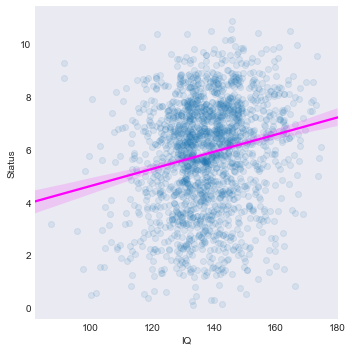

In [90]:
print('Correlation:', round(np.corrcoef(data.Status, data.IQ)[0,1], 3))

sns.lmplot('IQ', 'Status', data=data[data.IQ != data.IQ.median()],
            y_jitter=.9, x_jitter=3, scatter_kws={'alpha':.1}, line_kws={'color': 'magenta'})

# Life Outcomes

Let's look at the correlates for:

- RomanticLife
- FinancialSituation & Income
- LifeSatisfaction & MoodScale

The usual warning of correlation does not equal causation applies.

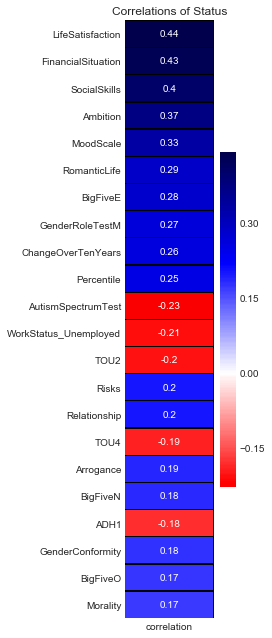

In [122]:
def absolute_correlations(col, df=data, ascending=False):
    corrs = pd.DataFrame(df.select_dtypes(include=[np.number]).corrwith(df[col]), columns=['correlation'])
    corrs['absol'] = np.abs(corrs['correlation'])
    if ascending == False:
        return corrs.sort_values('absol', ascending=ascending).drop('absol', axis=1).tail(len(corrs)-1)
    else:
        return corrs.sort_values('absol', ascending=ascending).drop('absol', axis=1).head(len(corrs)-1)

def corrmap(df, cutoff=0.2, title='Correlations'):
    top_corrs = df[abs(df.correlation) > cutoff]
    plt.figure(figsize=(2,len(top_corrs)//2))
    plt.title(title)
    sns.heatmap(top_corrs, annot=True, fmt='.2g', cmap='seismic_r',
                center=0, linecolor='black', linewidths=.25)

# Status
status = absolute_correlations('Status', ascending=False)
corrmap(status, cutoff=.17, title='Correlations of Status')

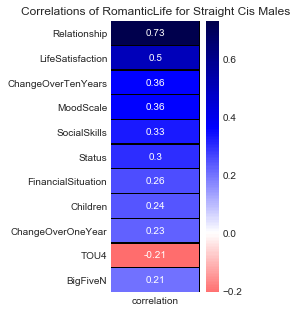

In [119]:
# Romantic life for straight cis males
scm = data[(data['Gender_M (cisgender)'] == 1) & (data['SexualOrientation_Heterosexual']) & (data['Sex_Male'] == 1)]

status = absolute_correlations('RomanticLife', df=scm, ascending=False)
corrmap(status, cutoff=.20, title='Correlations of RomanticLife for Straight Cis Males')

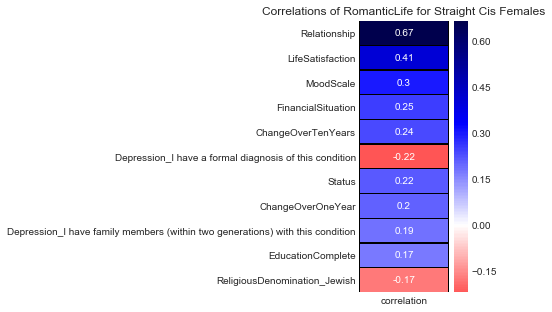

In [121]:
# Romantic life for straight cis females
scf = data[(data['Gender_F (cisgender)'] == 1) & data['SexualOrientation_Heterosexual'] & (data['Sex_Female'] == 1)]

status = absolute_correlations('RomanticLife', df=scf, ascending=False)
corrmap(status, cutoff=.17, title='Correlations of RomanticLife for Straight Cis Females')

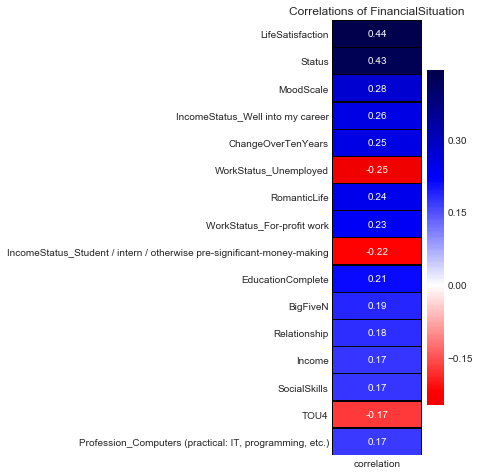

In [124]:
# FinancialSituation
finances = absolute_correlations('FinancialSituation', ascending=False)
corrmap(finances, cutoff=.17, title='Correlations of FinancialSituation')

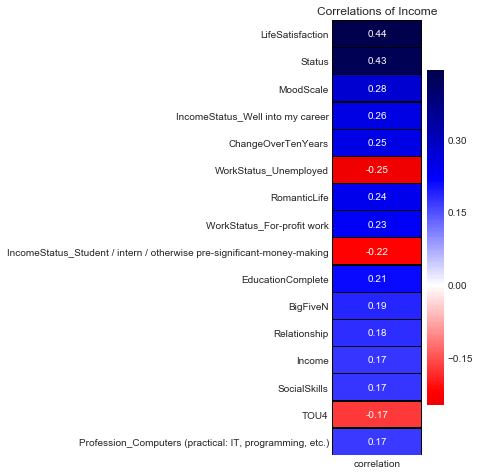

In [125]:
# Income
income = absolute_correlations('Income', ascending=False)
corrmap(finances, cutoff=.17, title='Correlations of Income')

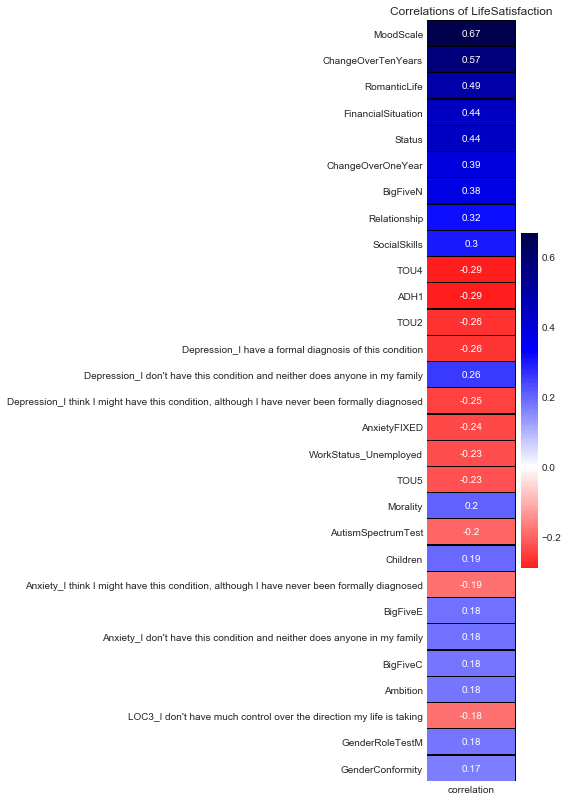

In [127]:
# LifeSatisfaction
satisfaction = absolute_correlations('LifeSatisfaction', ascending=False)
corrmap(satisfaction, cutoff=.17, title='Correlations of LifeSatisfaction')

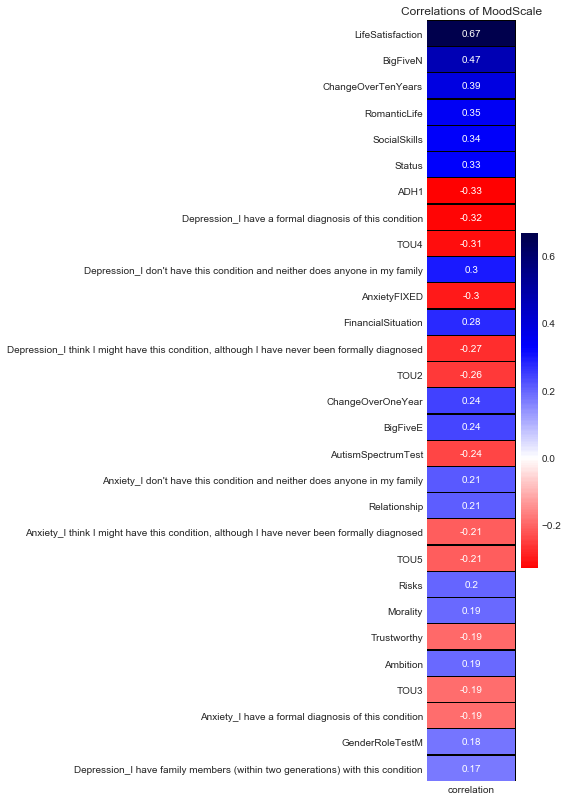

In [128]:
# MoodScale
mood = absolute_correlations('MoodScale', ascending=False)
corrmap(mood, cutoff=.17, title='Correlations of MoodScale')

There's something very odd here that I can't explain. Neuroticism is strongly correlated with MoodScale, but neuroticism is essentially synonymous with depression (I explain the difference as "neurotic" is a stable personality trait, while "depression" is a diagnosis that comes and goes. But it's fundamentally the same thing.).

I don't know why we're seeing this. However, we do see other, more logical predictors of mood, including social status, romantic life, and social skills.

# Personality

I think kdeplots look a bit better than histograms for graphing the big five personality traits. The distributions are a bit wonky, but a kdeplot can smooth them out and give us a better idea of what the population probably looks like.

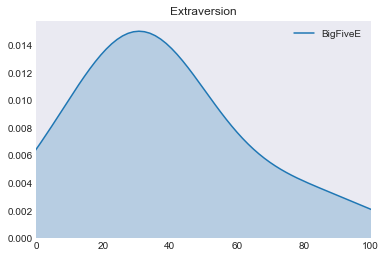

In [19]:
sns.kdeplot(data.BigFiveE, bw=18, shade=True)
plt.xlim(0,100)
plt.title('Extraversion')

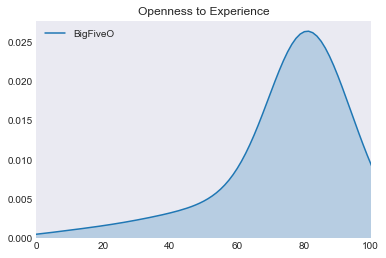

In [21]:
sns.kdeplot(data.BigFiveO, bw=10, shade=True)
plt.xlim(0,100)
plt.title('Openness to Experience')

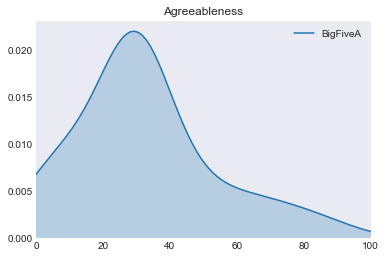

In [22]:
sns.kdeplot(data.BigFiveA, bw=10, shade=True)
plt.xlim(0,100)
plt.title('Agreeableness')

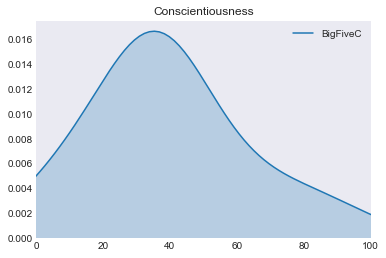

In [24]:
sns.kdeplot(data.BigFiveC, bw=15, shade=True)
plt.xlim(0,100)
plt.title('Conscientiousness')

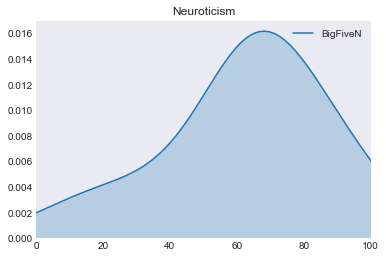

In [27]:
sns.kdeplot(data.BigFiveN, bw=15, shade=True)
plt.xlim(0,100)
plt.title('Neuroticism')

# Religion

In [195]:
rels = data[[i for i in data.columns if "Denom" in i]].copy()

atheists = data[[i for i in data.columns if 'Ath' in i and 'but spiritual' not in i]].sum(axis=1)
rels['ReligiousDenomination_Atheist'] = pd.Series(np.where(atheists >= 1, 1., 0)).copy()
rels['ReligiousDenomination_Other'] = pd.Series(np.where(atheists >= 1, 0, rels['ReligiousDenomination_Other'])).copy()

rels = rels.idxmax(axis=1)

rels_vcs = rels.value_counts()
rels_vcs = rels_vcs[rels_vcs > 10]

rels = np.where(rels.isin(rels_vcs.index), rels, 'ReligiousDenomination_Other')

data['Religion_categorial'] = pd.Series(rels)

data['Religion_categorial'].value_counts()

ReligiousDenomination_Atheist                                                  4007
ReligiousDenomination_Other                                                    1554
ReligiousDenomination_Christian (Protestant)                                    634
ReligiousDenomination_Christian (Catholic)                                      362
ReligiousDenomination_Jewish                                                    213
ReligiousDenomination_Buddhist                                                  113
ReligiousDenomination_Mixed/Other                                               107
ReligiousDenomination_Unitarian Universalism Or Similar                          82
ReligiousDenomination_Christian (Other Non-Protestant, Eg Eastern Orthodox)      72
ReligiousDenomination_Christian (Mormon)                                         53
ReligiousDenomination_Hindu                                                      41
ReligiousDenomination_Muslim                                                

The average life satisfaction of different religions...

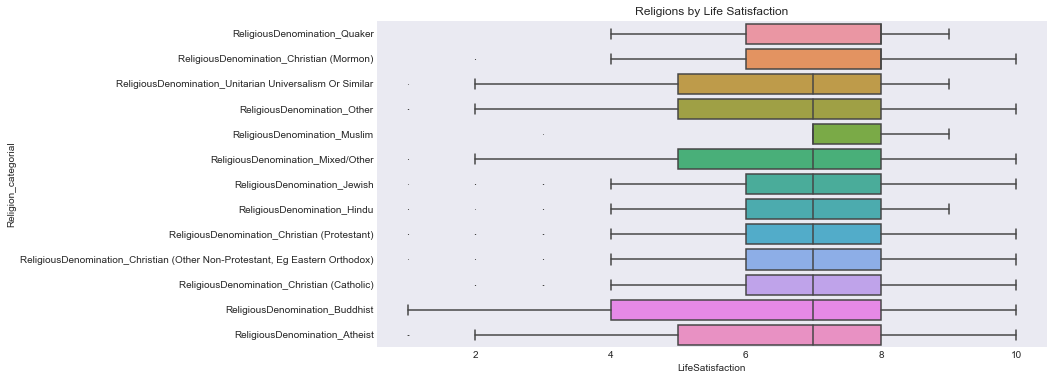

In [273]:
plt.figure(figsize=(12,6))

order = data.groupby('Religion_categorial').median()['LifeSatisfaction'].sort_values(ascending=False).index
sns.boxplot(data['LifeSatisfaction'], data['Religion_categorial'], whis=1, order=order, orient='h', fliersize=.2)
plt.title('Religions by Life Satisfaction')

Every other dataset I've ever examined has put Buddhists at, or near, the top. Granted, we have some small sample sizes, but this is not at all what I expected.

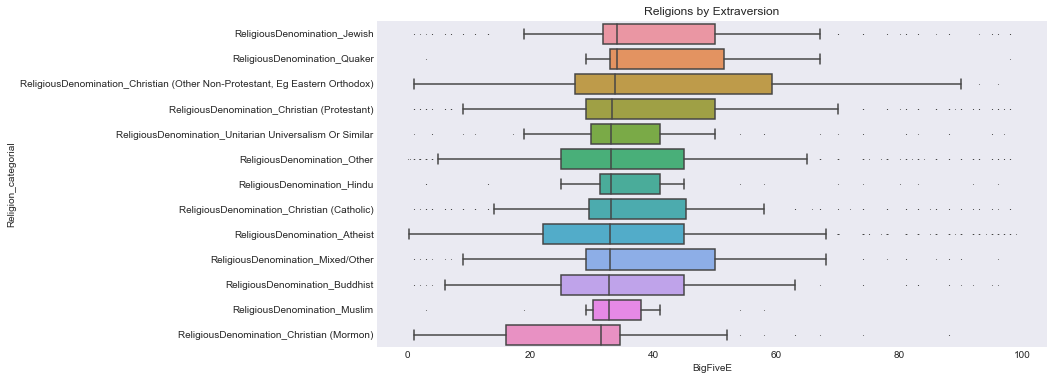

In [272]:
plt.figure(figsize=(12,6))

order = data.groupby('Religion_categorial').median()['BigFiveE'].sort_values(ascending=False).index
sns.boxplot(data['BigFiveE'], data['Religion_categorial'], whis=1, order=order, orient='h', fliersize=.2)
plt.title('Religions by Extraversion')

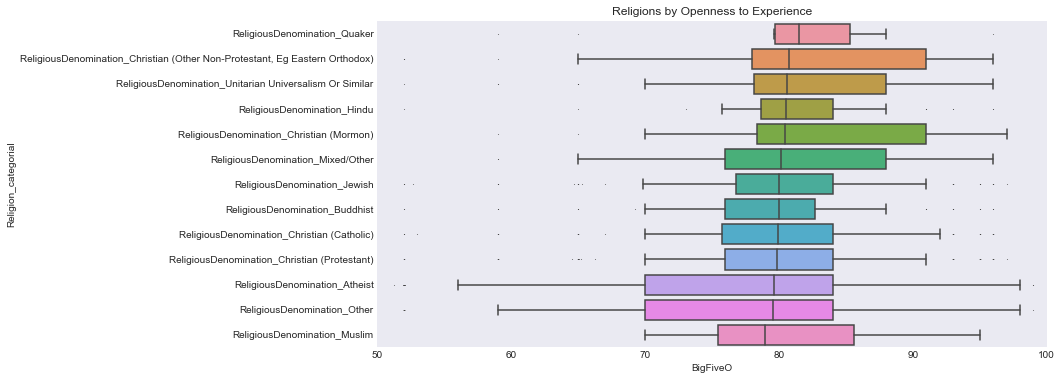

In [270]:
plt.figure(figsize=(12,6))
plt.xlim(50,100)

order = data.groupby('Religion_categorial').median()['BigFiveO'].sort_values(ascending=False).index
sns.boxplot(data['BigFiveO'], data['Religion_categorial'], whis=1, order=order, orient='h', fliersize=.2)
plt.title('Religions by Openness to Experience')

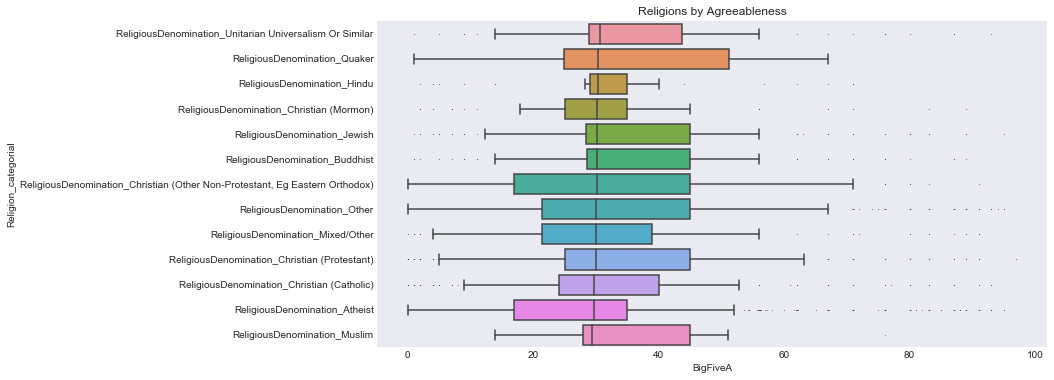

In [268]:
plt.figure(figsize=(12,6))

order = data.groupby('Religion_categorial').median()['BigFiveA'].sort_values(ascending=False).index
sns.boxplot(data['BigFiveA'], data['Religion_categorial'], whis=1, order=order, orient='h', fliersize=.2)
plt.title('Religions by Agreeableness')

# I thought this one was interesting. Maybe it's why new atheism failed?

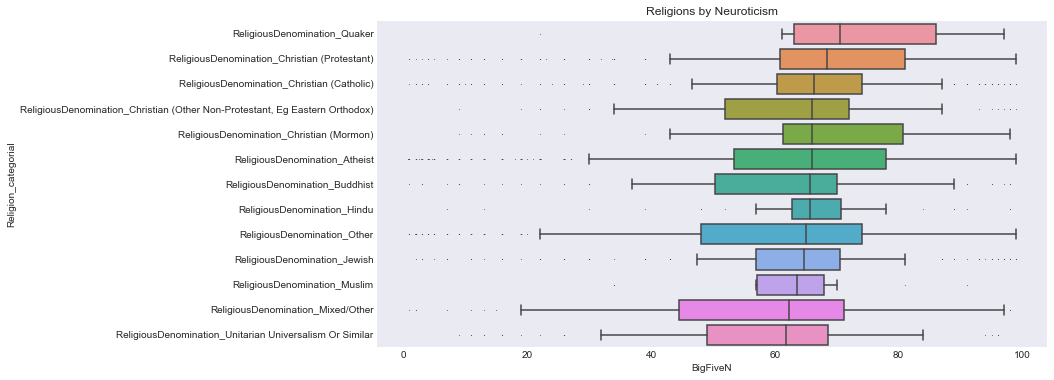

In [266]:
plt.figure(figsize=(12,6))

order = data.groupby('Religion_categorial').median()['BigFiveN'].sort_values(ascending=False).index
sns.boxplot(data['BigFiveN'], data['Religion_categorial'], whis=1, order=order, orient='h', fliersize=.2)
plt.title('Religions by Neuroticism')

In [285]:
from scipy.stats import ttest_ind

ttest_ind(data[data.Religion_categorial == 'ReligiousDenomination_Quaker']['BigFiveN'],
         data[data.Religion_categorial == 'ReligiousDenomination_Atheist']['BigFiveN'])

Ttest_indResult(statistic=1.1463277080711056, pvalue=0.25172787847682143)

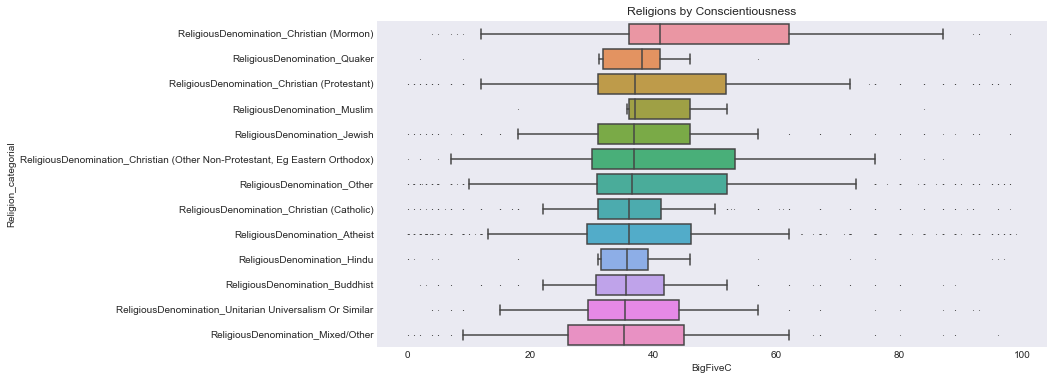

In [278]:
plt.figure(figsize=(12,6))

order = data.groupby('Religion_categorial').median()['BigFiveC'].sort_values(ascending=False).index
sns.boxplot(data['BigFiveC'], data['Religion_categorial'], whis=1, order=order, orient='h', fliersize=.2)
plt.title('Religions by Conscientiousness')

# Looks like the Mormon work ethic beats out the Protestant

In [280]:
data.groupby('Religion_categorial').median()['BigFiveC'].sort_values(ascending=False).index


Index(['ReligiousDenomination_Christian (Mormon)',
       'ReligiousDenomination_Quaker',
       'ReligiousDenomination_Christian (Protestant)',
       'ReligiousDenomination_Muslim', 'ReligiousDenomination_Jewish',
       'ReligiousDenomination_Christian (Other Non-Protestant, Eg Eastern Orthodox)',
       'ReligiousDenomination_Other',
       'ReligiousDenomination_Christian (Catholic)',
       'ReligiousDenomination_Atheist', 'ReligiousDenomination_Hindu',
       'ReligiousDenomination_Buddhist',
       'ReligiousDenomination_Unitarian Universalism Or Similar',
       'ReligiousDenomination_Mixed/Other'],
      dtype='object', name='Religion_categorial')

In [282]:
from scipy.stats import ttest_ind

ttest_ind(data[data.Religion_categorial == 'ReligiousDenomination_Christian (Mormon)']['BigFiveC'],
         data[data.Religion_categorial == 'ReligiousDenomination_Mixed/Other']['BigFiveC'])

Ttest_indResult(statistic=2.9869025785480878, pvalue=0.0032679089758385965)

In [215]:
degree = data[[i for i in data.columns if 'Degree' in i]]
degree = degree.idxmax(axis=1)

data['Degree_categorical'] = pd.Series(degree)

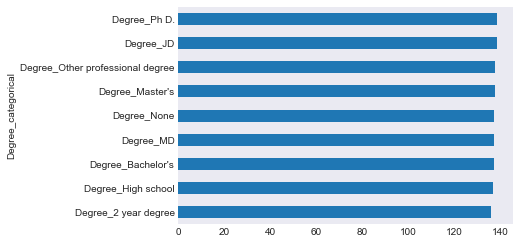

In [217]:
data.groupby('Degree_categorical').mean()['IQ'].sort_values().plot.barh()
plt.title('IQ by Degree')

# The order is about what you'd expect but there's no meaningful difference

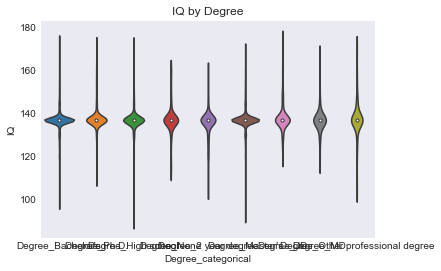

In [226]:
sns.violinplot(data['Degree_categorical'], data['IQ'])
plt.title('IQ by Degree')

# The order is about what you'd expect but there's no meaningful difference

In [ ]:
TODO:
    
- Correlation matrix
- IQ by education
- Factor analysis

In [153]:
(data["Autism_I have a formal diagnosis of this condition"].sum() + 
 data['Autism_I think I might have this condition, although I have never been formally diagnosed'].sum())/\
len(data)

0.1721763085399449

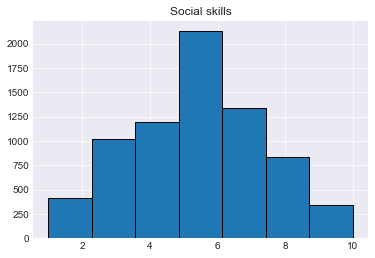

In [206]:
data['SocialSkills'].hist(edgecolor='black', bins=7)
plt.title('Social skills')

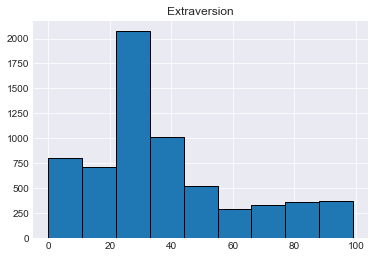

In [212]:
extraversion = list(data['BigFiveE'].fillna('none'))
for i, val in enumerate(extraversion):
    try:
        extraversion[i] = int(val)
    except:
        extraversion[i] = np.nan
        
extraversion = pd.Series(extraversion).dropna()

extraversion[extraversion != extraversion.median()].hist(bins=9, edgecolor='black')
plt.title('Extraversion')

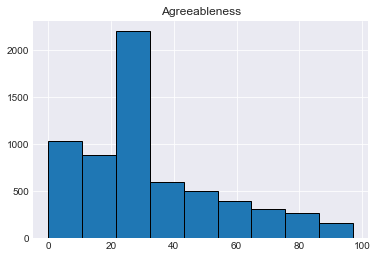

In [213]:
nums = list(np.arange(0,10,1))

extraversion = list(data['BigFiveA'].fillna('none'))
for i, val in enumerate(extraversion):
    try:
        extraversion[i] = int(val)
    except:
        extraversion[i] = np.nan
        
extraversion = pd.Series(extraversion).dropna()

extraversion[extraversion != extraversion.median()].hist(bins=9, edgecolor='black')
plt.title('Agreeableness')

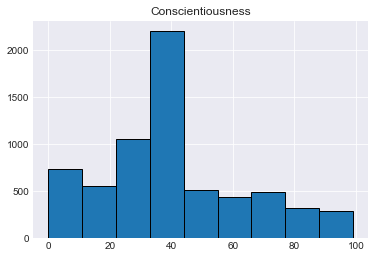

In [214]:
nums = list(np.arange(0,10,1))

extraversion = list(data['BigFiveC'].fillna('none'))
for i, val in enumerate(extraversion):
    try:
        extraversion[i] = int(val)
    except:
        extraversion[i] = np.nan
        
extraversion = pd.Series(extraversion).dropna()

extraversion[extraversion != extraversion.median()].hist(bins=9, edgecolor='black')
plt.title('Conscientiousness')

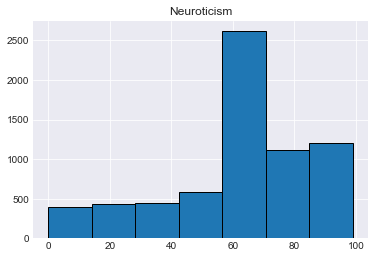

In [216]:
nums = list(np.arange(0,10,1))

extraversion = list(data['BigFiveN'].fillna('none'))
for i, val in enumerate(extraversion):
    try:
        extraversion[i] = int(val)
    except:
        extraversion[i] = np.nan
        
extraversion = pd.Series(extraversion).dropna()

extraversion[extraversion != extraversion.median()].hist(bins=7, edgecolor='black')
plt.title('Neuroticism')

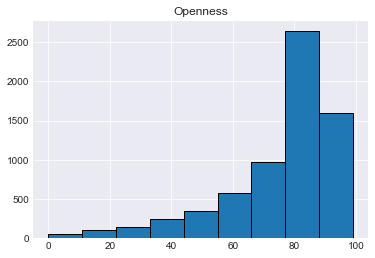

In [217]:
nums = list(np.arange(0,10,1))

extraversion = list(data['BigFiveO'].fillna('none'))
for i, val in enumerate(extraversion):
    try:
        extraversion[i] = int(val)
    except:
        extraversion[i] = np.nan
        
extraversion=pd.Series(extraversion)

extraversion = pd.Series(extraversion).dropna()

extraversion[(extraversion != extraversion.median()) & (extraversion <= 100)].hist(bins=9, edgecolor='black')
plt.title('Openness')

In [218]:
pd.to_numeric(data['Income'], errors='coerce', downcast='unsigned').describe()

count    7.260000e+03
mean     9.378516e+04
std      2.649061e+05
min     -1.000000e+04
25%      3.900000e+04
50%      6.300000e+04
75%      1.000000e+05
max      1.500000e+07
Name: Income, dtype: float64

In [158]:
data['Alcoholism_I have family members (within two generations) with this condition'].sum()

2631.0

In [159]:
data['Alcoholism_I think I might have this condition, although I have never been formally diagnosed'].sum()

303.0

In [160]:
data['Alcoholism_I have a formal diagnosis of this condition'].sum()

49.0

In [161]:
len(data)

7260

In [162]:
352/7260

0.048484848484848485

In [163]:
data['Drugaddiction_I have a formal diagnosis of this condition'].sum()

21.0

In [165]:
data['Drugaddiction_I think I might have this condition, although I have never been formally diagnosed'].sum()

141.0

In [166]:
162/7260

0.02231404958677686

In [167]:
.sum()

1284.0

In [168]:
.sum()

1133.0

In [169]:
2417/7260

0.33292011019283746

In [170]:
depression = data['Depression_I have a formal diagnosis of this condition'] + data['Depression_I think I might have this condition, although I have never been formally diagnosed']

In [172]:
pd.DataFrame(data.corrwith(depression)).sort_values(0)

,0
Depression_I don't have this condition and neither does anyone in my family,-0.568572
MoodScale,-0.469245
BigFiveN,-0.449746
Depression_I have family members (within two generations) with this condition,-0.405172
LifeSatisfaction,-0.400210
Anxiety_I don't have this condition and neither does anyone in my family,-0.282446
FinancialSituation,-0.217640
Status,-0.202731
RomanticLife,-0.197177
ChangeOverTenYears,-0.191279


In [173]:
alcoholism = data['Alcoholism_I think I might have this condition, although I have never been formally diagnosed'] + data['Alcoholism_I have a formal diagnosis of this condition']

In [175]:
pd.DataFrame(data.corrwith(alcoholism)).sort_values(0)

,0
Alcoholism_I don't have this condition and neither does anyone in my family,-0.255617
Alcoholism_I have family members (within two generations) with this condition,-0.170181
Harassment4_No,-0.101422
Drugaddiction_I don't have this condition and neither does anyone in my family,-0.090528
SATscoresoutof2400,-0.087673
BigFiveN,-0.078921
Depression_I don't have this condition and neither does anyone in my family,-0.077956
LifeSatisfaction,-0.073593
Anxiety_I don't have this condition and neither does anyone in my family,-0.071389
Morality,-0.062543


In [196]:
np.corrcoef(alcoholism, data.BigFiveN.fillna(data.BigFiveN.mean()))

array([[ 1.        , -0.05812254],
       [-0.05812254,  1.        ]])

In [179]:
drug_addiction = data['Drugaddiction_I think I might have this condition, although I have never been formally diagnosed'] +\
data['Drugaddiction_I have a formal diagnosis of this condition']

In [181]:
np.corrcoef(drug_addiction, data.BigFiveN.fillna(data.BigFiveN.mean()))

array([[ 1.        , -0.05235133],
       [-0.05235133,  1.        ]])

In [182]:
np.corrcoef(drug_addiction, data.BigFiveC.fillna(data.BigFiveN.mean()))

array([[ 1.       , -0.0234481],
       [-0.0234481,  1.       ]])

In [198]:
pd.DataFrame(data.corrwith(data.IQ)).sort_values(0).dropna()

,0
SurgeonRiddle_I wasn't able to solve this without looking at the answer,-0.124615
State_Other,-0.110984
Comment_Never; I only lurk,-0.102368
Favoriteblog_Naked Capitalism,-0.101219
OlderBrothers,-0.092315
HiddenOpenThreads_No,-0.086705
Country_Germany,-0.085447
Wason_3 and red,-0.082944
Country_Finland,-0.078606
Wason_8 and red,-0.078385


In [318]:
data = pd.read_csv('ssc2018public_inferred.csv')


In [319]:
from sklearn.ensemble import IsolationForest
data = data[[i for i in data.columns if "BigFive" in i]]
iso = IsolationForest(contamination=.1).fit(data)

In [320]:
pred = iso.predict(data)

In [321]:
data = data[pred == 1]

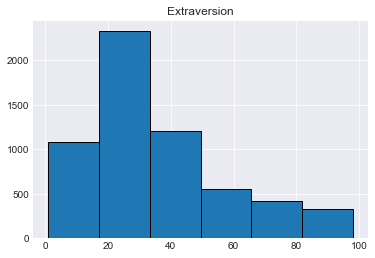

In [322]:
trait = list(data['BigFiveE'].fillna('none'))
for i, val in enumerate(trait):
    try:
        trait[i] = int(val)
    except:
        trait[i] = np.nan
        
trait = pd.Series(trait).dropna()

trait[trait != trait.median()].hist(bins=6, edgecolor='black')
plt.title('Extraversion')

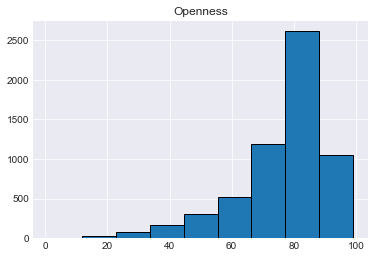

In [323]:
trait = list(data['BigFiveO'].fillna('none'))
for i, val in enumerate(trait):
    try:
        trait[i] = int(val)
    except:
        trait[i] = np.nan
        
trait = pd.Series(trait).dropna()

trait[trait != trait.median()].hist(bins=9, edgecolor='black')
plt.title('Openness')

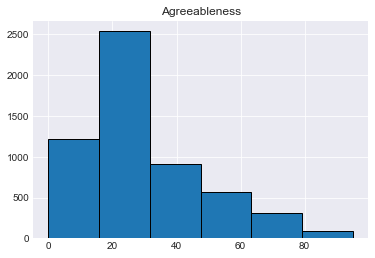

In [324]:
trait = list(data['BigFiveA'].fillna('none'))
for i, val in enumerate(trait):
    try:
        trait[i] = int(val)
    except:
        trait[i] = np.nan
        
trait = pd.Series(trait).dropna()

trait[trait != trait.median()].hist(bins=6, edgecolor='black')
plt.title('Agreeableness')

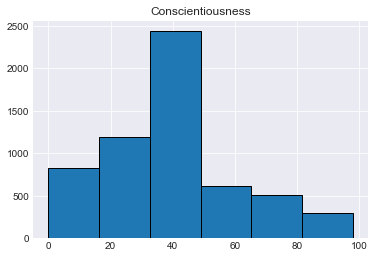

In [325]:
trait = list(data['BigFiveC'].fillna('none'))
for i, val in enumerate(trait):
    try:
        trait[i] = int(val)
    except:
        trait[i] = np.nan
        
trait = pd.Series(trait).dropna()

trait[trait != trait.median()].hist(bins=6, edgecolor='black')
plt.title('Conscientiousness')

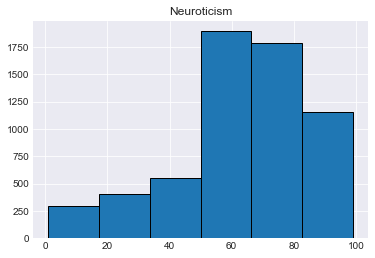

In [326]:
trait = list(data['BigFiveN'].fillna('none'))
for i, val in enumerate(trait):
    try:
        trait[i] = int(val)
    except:
        trait[i] = np.nan
        
trait = pd.Series(trait).dropna()

trait[trait != trait.median()].hist(bins=6, edgecolor='black')
plt.title('Neuroticism')

(0, 100)

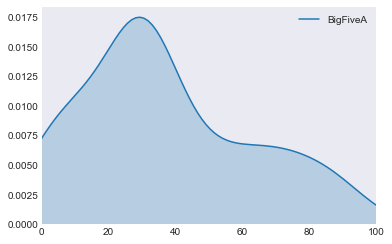

In [307]:
sns.kdeplot(data.BigFiveA, bw=10, shade=True)
plt.xlim(0,100)

(0, 100)

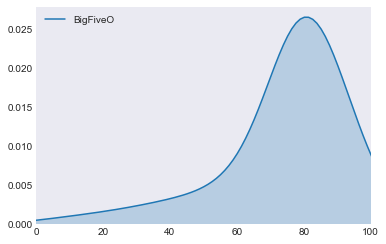

In [269]:
sns.kdeplot(data.BigFiveO, bw=10, shade=True)
plt.xlim(0,100)

(0, 100)

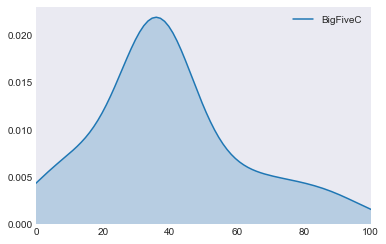

In [270]:
sns.kdeplot(data.BigFiveC, bw=10, shade=True)
plt.xlim(0,100)

In [292]:
data

,Timestamp,Age,GenderConformity,Children,ChildrenHappiness,GenderThoughts,EducationComplete,IQ,SATscoresoutof1600,SATscoresoutof2400,...,PoliticalDisagreementI_Other,"PoliticalDisagreementI_They Might Be Right About Some Things, I Can'T Be Sure Of My Position","PoliticalDisagreementI_They Seem Pretty Wrong, And Their Mistakes Seem Incomprehensible, Some Of Them Might Be Okay, I Guess","PoliticalDisagreementI_They Seem Pretty Wrong, But They Make Understandable Mistakes And Are Probably Mostly Decent People",PoliticalDisagreementII_Inexcusably Stupid Or Downright Evil,PoliticalDisagreementII_Other,"PoliticalDisagreementII_They Might Be Right About Some Things, I Can'T Be Sure Of My Position","PoliticalDisagreementII_They Seem Pretty Wrong, And Their Mistakes Seem Incomprehensible, Some Of Them Might Be Okay, I Guess","PoliticalDisagreementII_They Seem Pretty Wrong, But They Make Understandable Mistakes And Are Probably Mostly Decent People",Relationship


In [295]:
pd.Series(pred).value_counts()

 1    5808
-1    1452
dtype: int64